# Introduction

This notebook demonstrates the new capabilities introduced in `Amazon Titan Image Generator v2`, a powerful tool for generating and manipulating images using text prompts and reference visuals.


**1. Image Conditioning**

Generate outputs that follow the layout and structure of a user-supplied reference image by providing it along with a text prompt. Two modes are supported:

- Canny Edge: Extract prominent edges from the reference image to guide the generation process.
- Segmentation: Define specific regions/objects within the reference image for the model to generate content aligned with those areas.


**2. Color Conditioning**

Control the color palette of generated images by providing a list of hex color codes, adhering to brand color guidelines. Optionally, users can also supply a reference image to generate visuals that combine the specified color palette with the styling inherited from the reference.

**3. Background Removal**  

Automatically remove backgrounds from images containing multiple objects, isolating the foreground subjects.

# Pre-requisite

Before diving into the code examples, ensure you have the following

- An AWS account with access to Amazon Bedrock

- Enable Titan Image Generator v2 model access in Amazon Bedrock

- The necessary IAM permissions to invoke Amazon Bedrock models

- AWS SDK for Python (Boto3) installed


In [1]:
import base64
import io
import json
import logging
import boto3
import numpy as np

from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from botocore.exceptions import ClientError

bedrock_runtime_client = boto3.client("bedrock-runtime")

### Image Conditioning

Image conditioning allows users to guide image creation using a reference image. It supports two modes:

##### 1. Canny Edge

Canny edge uses edges from the reference image to guide structure and layout of the image

In [2]:
# Define the prompt and reference image
prompt = "a cartoon deer in a fairy world"
reference_image_path = "Data/deer.png"
seed = 50 # Can be any random number between 0 to 214783647

In [3]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "CANNY_EDGE", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

In [4]:
def plot_images(ref_image_path, base_images, prompt, seed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    reference_image = Image.open(ref_image_path)
    max_size = (300,300)
    reference_image.thumbnail(max_size)
    
    axes[0].imshow(np.array(reference_image))
    axes[0].set_title('Reference Image\n')
    axes[0].axis('off')

    axes[1].imshow(np.array(base_images[0]))
    axes[1].set_title('Image Generated Based on Reference\nSeed: {}'.format(seed))
    axes[1].axis('off')

    
    print("Prompt:{}\n".format(prompt))
    plt.show()

Prompt:a cartoon deer in a fairy world



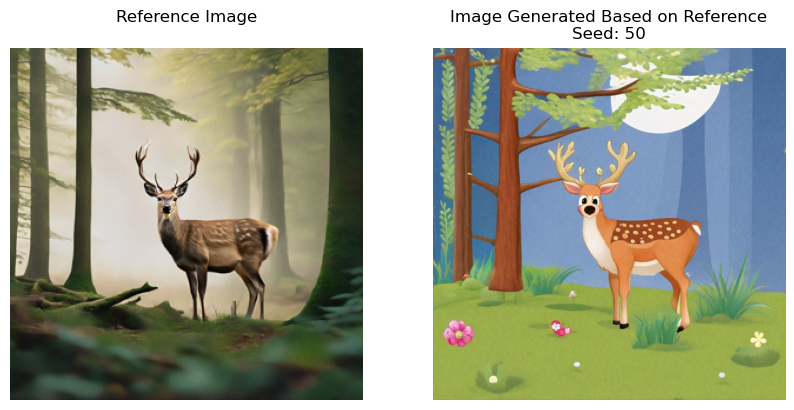

In [5]:
plot_images(reference_image_path, response_images, prompt, seed)

##### 2. Segmentation

Segmentation uses segmented regions from the reference image to control placement of specific elements

In [6]:
# Define the prompt and reference image
prompt = "car in driveway during sunset time"
reference_image_path = "Data/car_house.png"
seed = 50 # Can be any random number between 0 to 214783647

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "SEGMENTATION", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

In [8]:
def plot_images(ref_image_path, base_images, prompt, seed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    reference_image = Image.open(ref_image_path)
    max_size = (300,300)
    reference_image.thumbnail(max_size)
    
    axes[0].imshow(np.array(reference_image))
    axes[0].set_title('Reference Image\n')
    axes[0].axis('off')

    axes[1].imshow(np.array(base_images[0]))
    axes[1].set_title('Image Generated Based on Reference\nSeed: {}'.format(seed))
    axes[1].axis('off')

    
    print("Prompt:{}\n".format(prompt))
    plt.show()

Prompt:car in driveway during sunset time



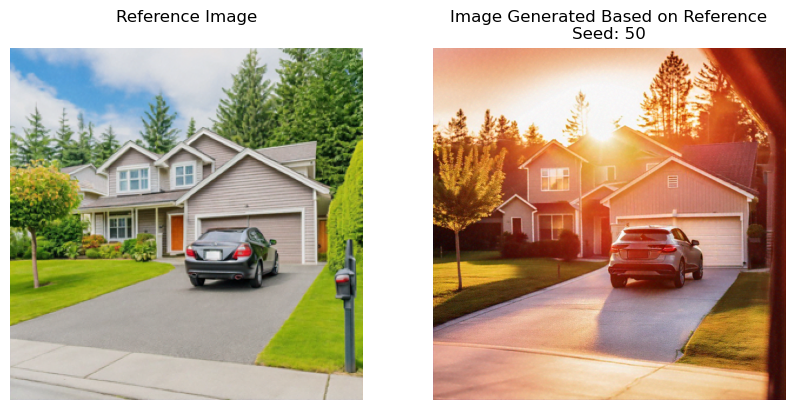

In [9]:
plot_images(reference_image_path, response_images, prompt, seed)

### Color Conditioning

Color conditioning enables control over the color palette of generated images by providing a list of hex color codes. This is useful for adhering to brand guidelines or specific design requirements.

In [10]:
# Define the prompt and reference image
prompt = "A cartoon image showing a laptop on the cloud"
hex_color_code = ['#FF9900', '#232F3E', '#F2F2F2', '#000000', '#146EB4']
seed = 10 # Can be any random number between 0 to 214783647

In [11]:
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

In [12]:
def plot_images(base_images, color_codes, prompt, seed):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Hex Color
    num_colors = len(color_codes)
    color_width = 0.8 / num_colors
    for i, color_code in enumerate(color_codes):
        x = i * color_width
        rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
        axes[0].add_patch(rect)
    axes[0].set_xlim(0, 0.8)
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Color Codes')
    axes[0].axis('off')

    axes[1].imshow(np.array(base_images[0]))
    axes[1].set_title(f'Image Generated\nSeed: {seed}')
    axes[1].axis('off')

    print(f"Prompt: {prompt}\n")
    plt.tight_layout()
    plt.show()

Prompt: A cartoon image showing a laptop on the cloud



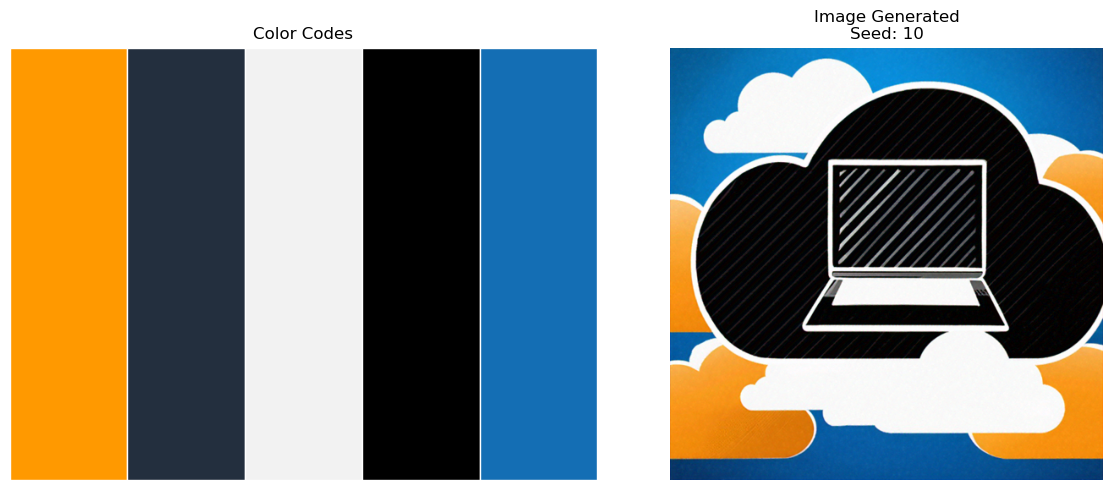

In [13]:
plot_images(response_images, hex_color_code, prompt, seed)

Additionally, users can upload refernce images similar to their desired output. The model will then generate images that follow the style and fashion of these refenrece images while incorporating the specified color palette.

In [14]:
# Define the prompt and reference image
prompt = "a ladybug on the flower"
reference_image_path = "Data/carton_ladybug.png"
hex_color_code = ["#ff8080", "#ffb280", "#ffe680", "#ffe680"]
seed = 10 # Can be any random number between 0 to 214783647

In [15]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
    
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code,
        "referenceImage": reference_image_base64
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

In [16]:
def plot_images(base_images, ref_image_path, color_codes, prompt, seed):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Hex Color
    num_colors = len(color_codes)
    color_width = 0.8 / num_colors
    for i, color_code in enumerate(color_codes):
        x = i * color_width
        rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
        axes[0].add_patch(rect)
    axes[0].set_xlim(0, 0.8)
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Color Codes')
    axes[0].axis('off')
    
    reference_image = Image.open(ref_image_path)
    max_size = (300,300)
    reference_image.thumbnail(max_size)

    axes[1].imshow(np.array(reference_image))
    axes[1].set_title('Reference Image\n')
    axes[1].axis('off')

    axes[2].imshow(np.array(base_images[0]))
    axes[2].set_title('Image Generated Based on Reference\nSeed: {}'.format(seed))
    axes[2].axis('off')

    print(f"Prompt: {prompt}\n")
    plt.tight_layout()
    plt.show()

Prompt: a ladybug on the flower



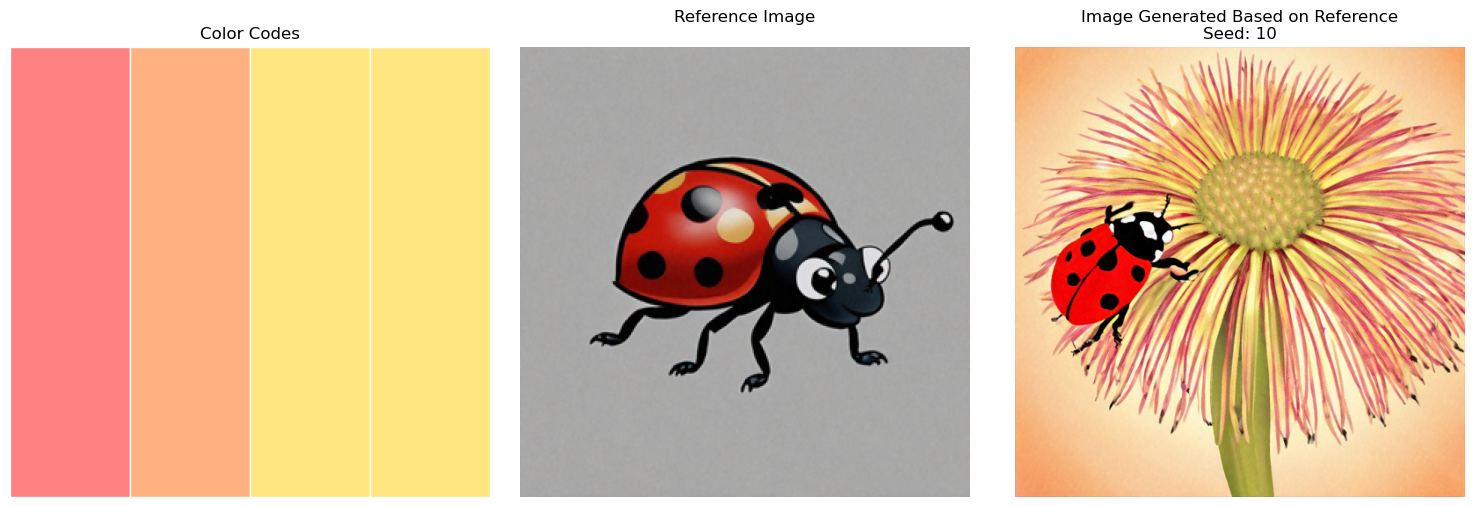

In [17]:
plot_images(response_images, reference_image_path, hex_color_code, prompt, seed)

### Background Removal

Background removal automatically removes the background from images containing multiple objects. This feature intelligently detects and segments foreground objects, isolating main elements with details.

In [18]:
# Define image needs to be processed
reference_image_path = "Data/iguana.png"

In [19]:
# Read image from file and encode it as base64 string.
with open(reference_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')

body = json.dumps({
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": input_image,
    }
})

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

In [20]:
def plot_images(ref_image_path, base_images):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    reference_image = Image.open(ref_image_path)
    max_size = (300,300)
    reference_image.thumbnail(max_size)
    
    axes[0].imshow(np.array(reference_image))
    axes[0].set_title('Original Image\n')
    axes[0].axis('off')

    axes[1].imshow(np.array(base_images[0]))
    axes[1].set_title('Processed Image without Background')
    axes[1].axis('off')

    plt.show()

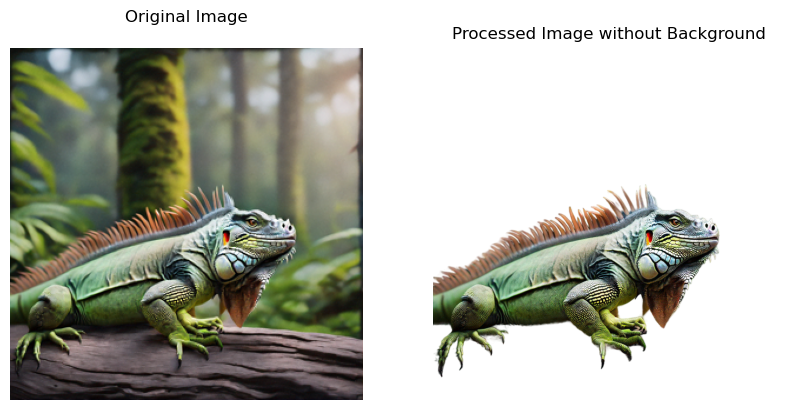

In [21]:
plot_images(reference_image_path, response_images)

# Take Away

Amazon Titan Image Generator v2 introduces advanced features such as image conditioning, color conditioning and background removal, enhacing the capabilities of AI-driven image generation. We encourage users to explore these new functionalities within Amazon Bedrock to experience the expanded potential for creating precise, customized visual contents.